In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

from torchvision.transforms import InterpolationMode
NEAREST = InterpolationMode.NEAREST

# from detectron2.projects.point_rend.point_features import point_sample
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import cv2

import clip_utils
from configs.dataset_cfg import dataset_info, prompt_templates

from clip_self_correlation import _transform1, _transform2, gt_transform, get_image_name_list, get_image_and_gt, device

In [5]:
def get_visual_features(clip, images):
    visual_features, attn_weights = clip.encode_image_origin(images)
    # b,hw+1,512     12,b,hw+1,hw+1
    visual_features = visual_features/visual_features.norm(dim=-1, keepdim=True)
    return visual_features, attn_weights

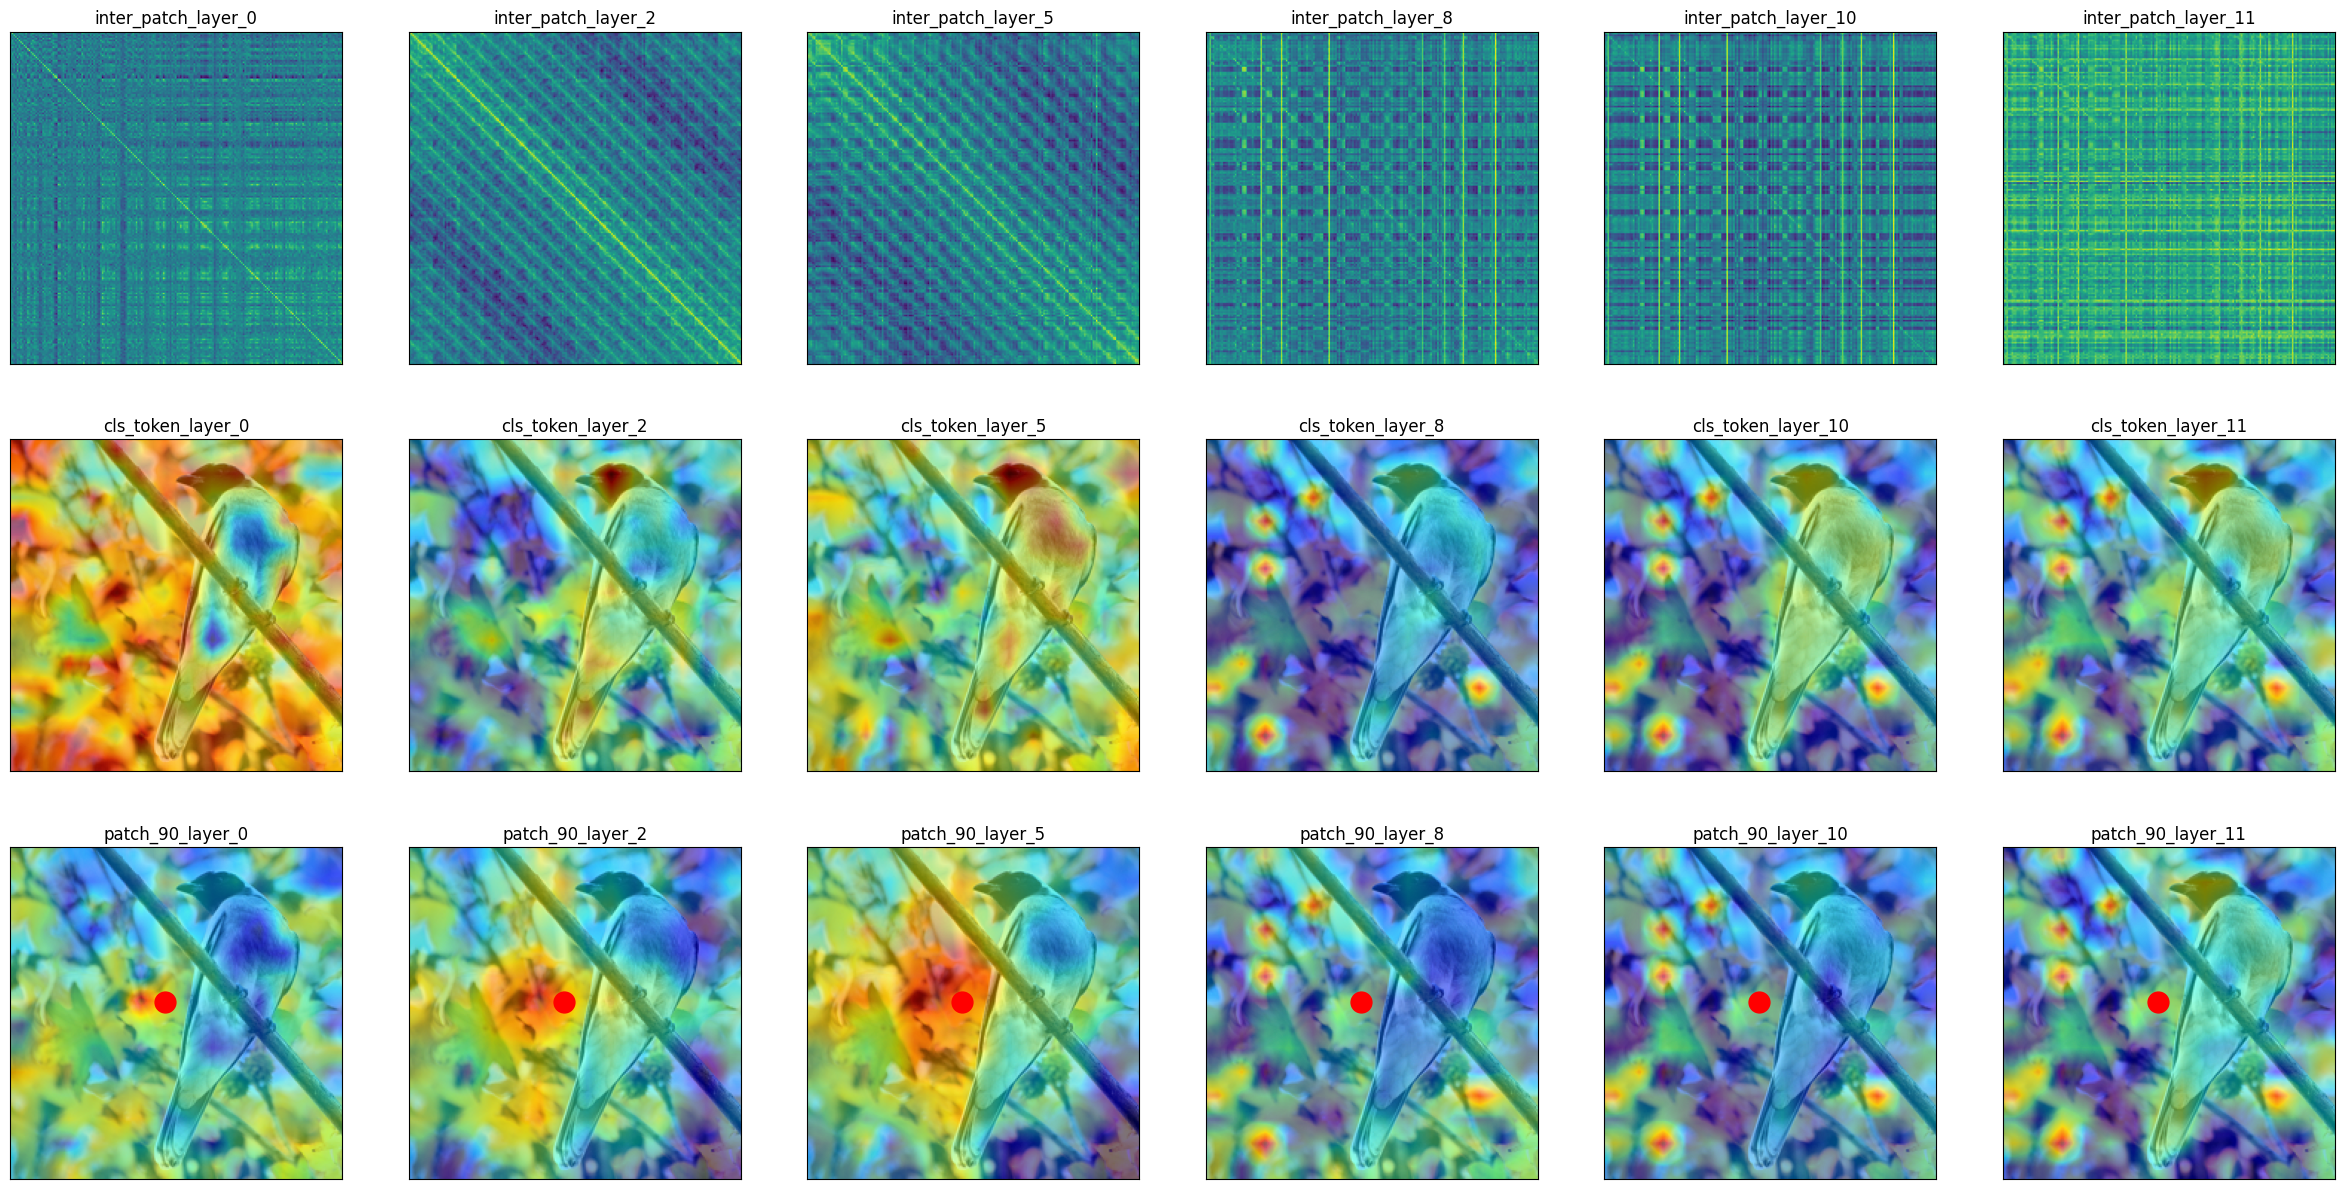

In [15]:
dataset = 'VOC20'
image_size = 224
clip_type = "ViT-B/16"
clip, _ = clip_utils.load(clip_type, image_size=224) # origin transforms unused
clip = clip.to(device)

# image
image_path = dataset_info[dataset]["image_path"]
gt_path = dataset_info[dataset]["gt_path"]
image_name_list = get_image_name_list(dataset,image_path)
image_file = '2009_003378.jpg'

ori_images, gts = get_image_and_gt(dataset, image_size, image_path, gt_path, image_file)
ori_h, ori_w = gts.shape[-2:]
images = _transform2()(ori_images).to(device)
# visual features
patch_window = 16
h,w = images.shape[-2]//patch_window, images.shape[-1]//patch_window
visual_features, attn_weights = get_visual_features(clip,images.unsqueeze(0))

# layer sample
layer_idxs = [0,2,5,8,10,11]
layers = len(layer_idxs)
attn_weights = attn_weights[layer_idxs,0] # n,hw+1,hw+1

# patch sample
patch_idxs = 90

plt.figure(figsize=(30,15))
for i in range(layers):
    # inter-patch weights
    plt.subplot(3,layers,i+1)
    plt.imshow(attn_weights[i,1:,1:].detach().cpu().numpy())
    plt.title('inter_patch_layer_'+str(layer_idxs[i]))
    plt.xticks([])
    plt.yticks([])
    # cls token weights
    plt.subplot(3,layers,i+layers+1)
    cls_token = attn_weights[i,0,1:] # hw
    cls_token = cls_token.reshape(h,w)
    cls_token = F.interpolate(cls_token.unsqueeze(0).unsqueeze(0), size=(image_size, image_size), mode='bilinear',align_corners=False)[0,0]
    plt.imshow(ori_images)
    plt.imshow(cls_token.detach().cpu().numpy(),alpha=0.5,cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.title('cls_token_layer_'+str(layer_idxs[i]))
    # selected patch weights
    plt.subplot(3,layers,i+2*layers+1)
    patch_token = attn_weights[i,patch_idxs,1:] # hw
    patch_token = patch_token.reshape(h,w)
    patch_token = F.interpolate(patch_token.unsqueeze(0).unsqueeze(0), size=(image_size, image_size), mode='bilinear',align_corners=False)[0,0]
    plt.imshow(ori_images)
    plt.imshow(patch_token.detach().cpu().numpy(),alpha=0.5,cmap='jet')
    col = (patch_idxs//w)*patch_window+patch_window//2
    row = (patch_idxs%w)*patch_window+patch_window//2
    plt.plot(row,col,'ro',markersize=15)
    plt.xticks([])
    plt.yticks([])
    plt.title('patch_'+str(patch_idxs)+'_layer_'+str(layer_idxs[i]))



